# Support vector machine classifier (SVM)

In this notebook we implement a multiclass SVM classifier for image classification on the CIFAR-10 dataset.

**Technical features:**

* Vectorized loss/gradient models
* Gradient verification via finite differences
* Mini-batch gradient descent
* Hyperparameter tuning

## **Model overview**

* Input: Image $X$, reshaped into an $D$-dimensional vector, here regarded as a column vector as per the linear algebra convention.
    * Caveat: In the code, $X$ is a row vector, so $X$ and other parts of this description may also require transposition when transferring to code.
* Target: Predicted label $y\in \text{labels} = \{1,\ldots,C\}$, where $\text{labels}$ is a set of $C$ classification labels for each image (e.g. "cat", "boat", etc).
* Model parameters:
    * $W\in M_{C\times N}(\mathbb{R})$: a $C\times D$ matrix of weights, regarded as a map $\mathbb{R}^D\to\mathbb{R}^C$.
    * Hyperparameters:
        * $\alpha\in\mathbb{R}_{>0}$: regularization strength. Controls strength of the regularization term $\lambda\|W\|_2^2$.
        * $\epsilon\in\mathbb{R}_{>0}$:  learning rate. Step size for stochastic gradient descent, used during training.
        * $\beta\in\mathbb{N}$: batch size. Sampling size for stochastic gradient descent, used during training.

**Prediction generation algorithm:**

1. Take image $X$ as input.
2. Compute $s(X) = (s(X)_1,\ldots,s(X)_C) = WX \in \mathbb{R}^C$. This vector represents a list of scores for $X$ corresponding to each label in $\text{labels}$. (General SVMs will also have a bias term $b\in\mathbb{R}^C$, so that $s(X) = W\cdot X + b$.)
3. Generate prediction $y$ by taking the label corresponding to the highest score in $s(X)$, i.e. $y = \argmax \{s(X)_i: i=1,\ldots,C\}.$


## **Training**

Training the model consists of generating the matrix of weights $W$ from the training data $\{(X_t,y_t)\}$.

### **1. Construct the loss functional from the training data**

For a given matrix $W$ and a training dataset $\{(X_t,y_t)\}$ (which we regard as fixed), we define the loss functional $\mathcal{L}(W;\{(X_t,y_t)\}) = \mathcal{L}(W)$ as follows:

* For a given image $X$, we set $f(X,W) = s(X,W) = s(X) = WX$ (more generally, $f(X,W) = WX + b$). In particular, $s(X)_y$ is the score of the label $y$ in the image-label pair $(X,y)$.
* Define the loss functional for the image-label pair $(X,y)$ by the SVM loss function $$L(f(X,W),y) = L(s(X),y) = \sum_{j \neq y} \max(0,s(X)_j - s(X)_y + 1).$$
* Define the total loss functional as the average of the loss over the entire training dataset, plus a regularization term: $$\mathcal{L}(W;\{(X_t,y_t)\}) = \frac{1}{N}\sum_{(X_t,y_t)} L(f(X_t,W),y_t) + \alpha R(W)$$
where $N = |\{(X_t,y_t)\}|$, $\alpha$ is the regularization strength, and $R(W) = \|W\|_2^2$ (other functions of $W$ are possible for $R$ too). The regularization helps prevent over-fitting by introducing a data-independent term to the loss.

### **2. Optimize the loss functional in $W$**

Once the loss functional $\mathcal{L}(W;\{(X_t,y_t)\})$ has been constructed from $\{(X_t,y_t)\}$, we regard the training data as fixed and $\mathcal{L}$ as a function of $W$ only: $\mathcal{L} = \mathcal{L}(W)$. We then seek the $W$ that minimizes the average loss, i.e. $$W = \argmin_V \mathcal{L}(V).$$

We accomplish this by gradient descent.

1. Compute the gradient matrix $\nabla_W\mathcal{L}$ by $$(\nabla_W \mathcal{L})_{ij} = \frac{\partial\mathcal{L}}{\partial W_{ij}};$$ it is a matrix of the same dimensions as $W$.
    
    a. The individual components are given by the following formula:
    $$
        [\nabla_W \mathcal{L}]_{ij} = \frac{1}{N} \sum_{(X_t,y_t)} \sum_{k\neq y_t} 1_{s(X_t)_k - s(X_t)_{y_t} + 1 > 0}(\delta_{ik} -\delta_{iy_t})(X_t)_j + 2\alpha W_{ij}.
    $$
    
2. Initialize $W^{(0)}$ as a small random matrix, then define iterates $W_n$ by $$W^{(n+1)} = W^{(n)} -\epsilon(\nabla_W\mathcal{L})(W^{(n)})$$
where $\epsilon$ is the learning rate. Continue iterations until $W^{(n)}$ is sufficiently close to the true minimizer of $\mathcal{L}$.

**Sanity checking with FDM:**

The correctness of the analytic (exact) gradient formulas can be verified by implementing a numerical gradient descent using the finite difference method. However, the finite difference method is expensive in practice, so it should only used for verification and not for training the full model.

**Mini-batching:**

For performance, we add an optimization to this procedure called mini-batching (sometimes also called stochastic gradient descent):

1. Instead of computing the loss functional $\mathcal{L}$ using all of the training data $\{(X_t,y_t)\}$, during each iteration of gradient descent we randomly select a subset $B\subset\{(X_t,y_t)\}$ called a *batch*, then compute the loss functional using only training data $(X_t,y_t)$ selected from $B$.
2. We perform all subsequent gradient and gradient descent calculations during this parameter update using this $\mathcal{L}$.

In practice this usually produces a good enough approximation to gradient descent with the full training data, the idea being that $\mathcal{L}$ is an average and a randomly selected sample of the training data should represent it sufficiently well to reproduce $\mathcal{L}$ on average.

## Hyperparameter tuning:

The model takes the hyperparameters $\epsilon$ (learning rate), $\alpha$ (regularization strength), and $\beta$ (batch size). The provided notebook performs hyperparameter tuning in $\epsilon$ and $\alpha$.

## Performance:

With a good choice of hyperparameters the model can predict labels in the test dataset with ~38% accuracy.


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from model.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = '../datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


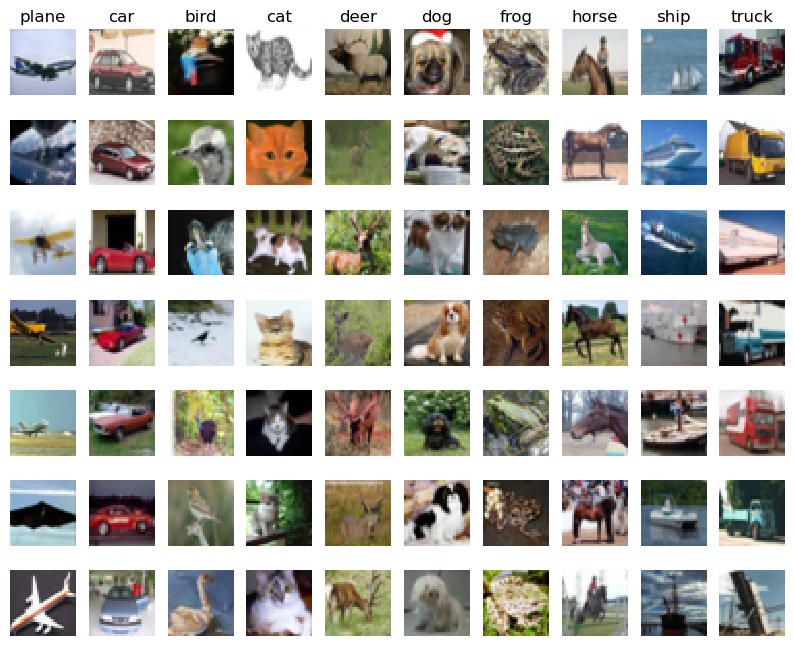

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


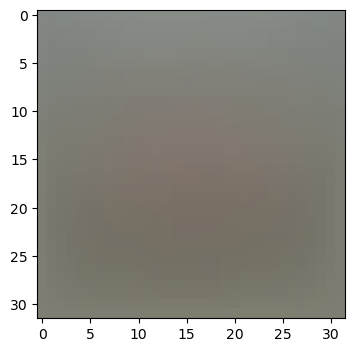

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

In [7]:
from model.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

# Verify correctness of gradient implementation in svm_loss_naive
# by comparing its gradient descent with gradient descent using
# finite differences method

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with  analytically computed gradient. The numbers should match
# almost exactly along all dimensions.

from model.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on

loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -34.647052 analytic: -34.647052, relative error: 1.117042e-11
numerical: 7.234671 analytic: 7.234671, relative error: 1.442413e-11
numerical: -0.707108 analytic: -0.707108, relative error: 2.532024e-10
numerical: 23.310599 analytic: 23.310599, relative error: 2.933161e-12
numerical: -11.485095 analytic: -11.485095, relative error: 1.910902e-13
numerical: -0.259135 analytic: -0.259135, relative error: 2.615125e-10
numerical: 31.564329 analytic: 31.564329, relative error: 7.310428e-13
numerical: -1.325014 analytic: -1.325014, relative error: 8.008358e-11
numerical: 19.716883 analytic: 19.716883, relative error: 9.109953e-12
numerical: -1.868306 analytic: -1.868306, relative error: 4.470114e-12
numerical: -7.897167 analytic: -7.897167, relative error: 3.998462e-12
numerical: -6.218651 analytic: -6.218651, relative error: 2.962832e-12
numerical: 15.122157 analytic: 15.122157, relative error: 2.550506e-11
numerical: 0.138965 analytic: 0.138965, relative error: 3.213305e-10
numeri

In [8]:
# Verify that vectorized loss and gradient calculations are correct
# by comparing with non-vectorized version

tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from model.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized model should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.343757e+00 computed in 0.064001s
Vectorized loss: 9.343757e+00 computed in 0.008000s
difference: -0.000000


In [9]:
# Verify that vectorized version is much faster

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.067996s
Vectorized loss and gradient: computed in 0.007001s
difference: 0.000000


### Stochastic Gradient Descent

In [10]:
# Train model using vectorized loss and gradient
# Verify correctness by checking that stochastic gradient descent
# minimizes the loss

from model.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 799.836026
iteration 100 / 1500: loss 291.421022
iteration 200 / 1500: loss 109.323515
iteration 300 / 1500: loss 43.555249
iteration 400 / 1500: loss 18.913304
iteration 500 / 1500: loss 10.020659
iteration 600 / 1500: loss 7.327230
iteration 700 / 1500: loss 5.937736
iteration 800 / 1500: loss 5.541264
iteration 900 / 1500: loss 5.526673
iteration 1000 / 1500: loss 5.519407
iteration 1100 / 1500: loss 5.069758
iteration 1200 / 1500: loss 5.849900
iteration 1300 / 1500: loss 5.359155
iteration 1400 / 1500: loss 5.516558
That took 8.115000s


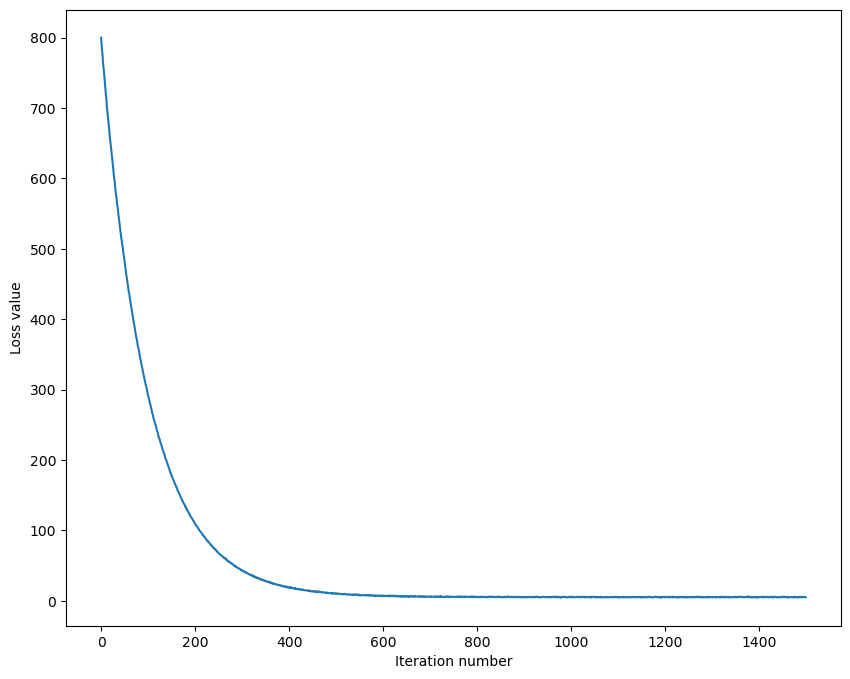

In [11]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [12]:
# Evaluate the performance on both the training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.365959
validation accuracy: 0.381000


In [13]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# For each combination of hyperparameters, train a linear SVM on the           #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Tip: You should use a small value for num_iters as you develop your          #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# You may or may not want to change these hyperparameters
# learning_rates should initially be set as np.logspace(start,stop,num_points)
# to get order of magnitude before further tuning
learning_rates = [1.875000e-07]
regularization_strengths = [2.250000e+04]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
from copy import deepcopy

for lr in learning_rates:
  for reg in regularization_strengths:
    validation_svm = LinearSVM()
    validation_svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters = 4096, batch_size=512)
    y_train_pred = validation_svm.predict(X_train)
    y_val_pred = validation_svm.predict(X_val)
    tr_acc = np.mean(y_train == y_train_pred)
    val_acc = np.mean(y_val == y_val_pred)
    results.update({tuple([lr,reg]): tuple([tr_acc,val_acc])})
    if val_acc > best_val:
      best_val = val_acc
      best_svm = deepcopy(validation_svm)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.875000e-07 reg 2.250000e+04 train accuracy: 0.374224 val accuracy: 0.392000
best validation accuracy achieved during cross-validation: 0.392000


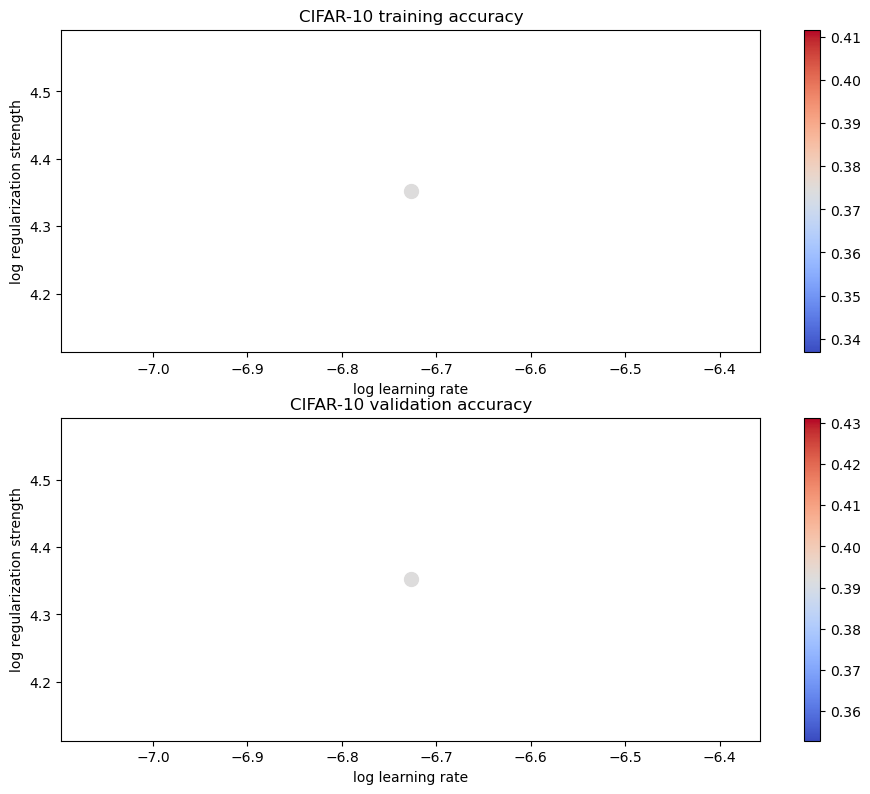

In [14]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [15]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.370000


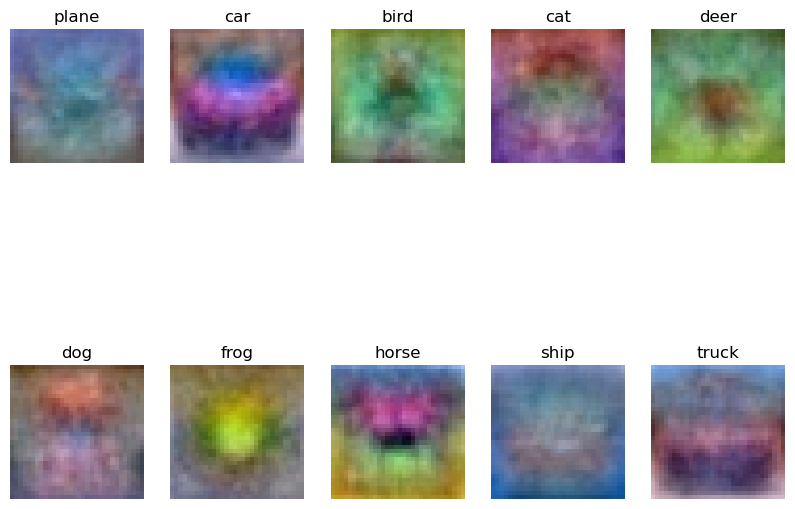

In [16]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])